In [6]:
import pandas as pd
import therpy as tp
import numpy as np
from tqdm import tqdm_notebook as tqdm
import bec1db as bec1db_package
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
bec1db = bec1db_package.Tullia(delta=15)

The servers are not connected!
Using the local database copy. Could be outdated!


# df_from_clipboard

In [7]:
import IPython.display
Image = tp.Image

def images_from_clipboard(df=None, x='time', params=[], image_func=Image, download='ABS', display=False, verify=False, keep_all=False):
    '''
    Get a list of images from clipboard and desired experimental parameters 
    Inputs
        df = None : if you desire to add images to already polulated dataframe 
        x = None : a string specifying the x parameter, default will be set to image time in minutes 
        params = [] : a list of string, the names of parameters you want to add to the dataframe, in addition to x 
        image_func = tp.Image : the function that takes in imagename string and returns image object, tp.Image or tp.Hybrid_Image
        download = 'ABS' : which images to download ==> 'A', 'B', 'S', 'AB', 'SB', 'ABS', 'SAB' 
        display = False : wether to print some information or not 
        verify = False : Remove any file that doesn't have its partners. For example if S present, but AB missing, in case uing='ABS'
        keep_all = False : wether to keep images that are not part of download
    '''
    # Generate new empty dataframe if not provided 
    if df is None: df = pd.DataFrame()
    
    # Fix the list of parameters 
    required_params = ['name','time','image','A','B','S','download']
    if (x not in params) and (x != 'time'): params = params + x
    if 'unixtime' in params: params.remove('unixtime')
    
    # Prepare DataFrame for inserting new data 
    if df.size == 0: df = pd.DataFrame(None, columns = required_params + params).set_index('name')
    else:
        old_columns = df.columns.tolist() + [df.index.name]
        for n in (required_params + params):
            if n not in old_columns: df[n] = None
    
    # Get the list of filenames from clipboard and add them to DataFrame
    copied_names = pd.read_clipboard(header=None)[0].tolist()
    old_names = df.index.tolist()
    for n in copied_names:
        if n not in old_names: df.loc[n] = None
    df = df.sort_index()
    
    # Get the parameters 
    try: bec1db.refresh()
    except: pass
    df_params = bec1db.image_query(df.index.tolist(), params + ['unixtime'])
    df_params = df_params.rename(columns={'imagename':'name', 'unixtime':'time'}).set_index('name')
    for n in (params + ['time']):
        df[n] = df_params[n]
    
    # Fix the parameters 
    df.time = (df.time - df.time.min())/60
    df.A = [n[-1] == 'A' for n in df.index]
    df.B = [n[-1] == 'B' for n in df.index]
    df.S = [n[-1] not in ['A','B'] for n in df.index]
    df['x'] = df[x]
    
    # Add Images 
    download = list(download)
    df.download = (df.A & ('A' in download)) | (df.B & ('B' in download)) | (df.S & ('S' in download))
    for n in tqdm(df.index.values):
        if df.loc[n,'download'] and (type(df.loc[n,'image']) != image_func): df.loc[n, 'image'] = image_func(n)
    
    # Remove entries that are not in download 
    if not keep_all:
        df = df[df.download]
    
    # Verify if Required 
    if verify:
        remove_x = []
        reqd = ('A' in download) + ('B' in download) + ('S' in download)
        for x in np.unique(df.time):
            if df[(df.time == x) & df.download].shape[0] != reqd: remove_x.append(x)
        for x in remove_x:
            print('Removing ', df[df.time == x].index.values)
            df = df[df.time != x]
    
    # Display
    if display:
        print('Total Number of Shots {}, Images {}'.format(np.unique(df.time).shape[0],df.shape[0]))
        IPython.display.display(df.head(3))
    
    return df

images_from_clipboard = tp.images_from_clipboard

08-09-2017_20_09_26_TopB
08-09-2017_20_09_26_TopA
08-09-2017_20_08_36_TopA
08-09-2017_20_08_36_TopB
08-09-2017_20_09_23
08-09-2017_20_08_33

In [8]:
df = images_from_clipboard(df=None, x='time', params=[], image_func=str, download='AB', display=False, verify=False, keep_all = False)
df

,time,image,A,B,S,download,x
name,,,,,,,
08-09-2017_20_08_36_TopA,0,08-09-2017_20_08_36_TopA,True,False,False,True,0
08-09-2017_20_08_36_TopB,0,08-09-2017_20_08_36_TopB,False,True,False,True,0
08-09-2017_20_09_26_TopA,0.833333,08-09-2017_20_09_26_TopA,True,False,False,True,0.833333
08-09-2017_20_09_26_TopB,0.833333,08-09-2017_20_09_26_TopB,False,True,False,True,0.833333


In [9]:
df = images_from_clipboard(df=df, x='time', params=[], image_func=str, download='A', display=False, verify=False)
df

,time,image,A,B,S,download,x
name,,,,,,,
08-09-2017_20_08_36_TopA,0,08-09-2017_20_08_36_TopA,True,False,False,True,0
08-09-2017_20_09_26_TopA,0.833333,08-09-2017_20_09_26_TopA,True,False,False,True,0.833333


# Atom Num Filter

08-07-2017_23_49_04_TopA
08-07-2017_23_49_04_TopB
08-07-2017_23_48_07_TopA
08-07-2017_23_48_07_TopB
08-07-2017_23_47_12_TopA
08-07-2017_23_47_12_TopB
08-07-2017_23_46_17_TopA
08-07-2017_23_46_17_TopB
08-07-2017_23_45_20_TopA
08-07-2017_23_45_20_TopB
08-07-2017_23_44_25_TopA
08-07-2017_23_44_25_TopB
08-07-2017_23_43_30_TopA
08-07-2017_23_43_30_TopB
08-07-2017_23_42_33_TopA
08-07-2017_23_42_33_TopB
08-07-2017_23_41_38_TopA
08-07-2017_23_41_38_TopB
08-07-2017_23_40_44_TopA
08-07-2017_23_40_44_TopB
08-07-2017_23_39_47_TopA
08-07-2017_23_39_47_TopB
08-07-2017_23_38_52_TopA
08-07-2017_23_38_52_TopB
08-07-2017_23_37_57_TopA
08-07-2017_23_37_57_TopB
08-07-2017_23_37_02_TopA
08-07-2017_23_37_02_TopB

In [10]:
default_settings = dict(
   # Image Preparation and Background 
   center_x=1190, center_y=1350, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

,time,image,A,B,S,download,x,total_atoms
name,,,,,,,,
08-07-2017_23_37_02_TopA,0,Image object,True,False,False,True,0,278462
08-07-2017_23_37_57_TopA,0.916667,Image object,True,False,False,True,0.916667,262802
08-07-2017_23_38_52_TopA,1.83333,Image object,True,False,False,True,1.83333,256135
08-07-2017_23_39_47_TopA,2.75,Image object,True,False,False,True,2.75,265574
08-07-2017_23_40_44_TopA,3.7,Image object,True,False,False,True,3.7,278374


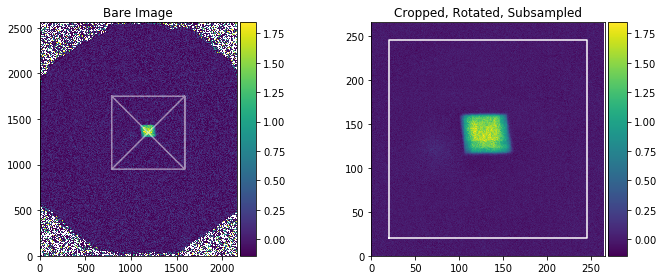

In [11]:
df = images_from_clipboard(download='A', display=False,)

# Apply image settings 
for im in df[df.download].image: im.set(**default_settings)
df[df.download].image.iloc[0].plot_crop()
df['total_atoms'] = None
for n in tqdm(df[df.download].index): df.loc[n, 'total_atoms'] = df.loc[n, 'image'].total_atoms
df.head()

In [12]:
def atom_num_filter(df, keep=0.10, offset=0.0, using='ABS', display=False, plot=False, ax=None):
    '''
    Filter atom number and store df.use bool array in the dataframe 
    Inputs : 
        df : the datafame where atom numebrs are calculated, output of images_from_clipboard 
        keep : fraction of atoms to keep from median value 
        offset : offset from median value ==> medial * (1+offset) 
        using : NOT YET IMPLEMENTED 
        display : print a summery of the number of images removed 
        plot : make a plot of atom numbers vs time and histogram of kept atoms 
        ax : optionally provide list of two axes to plot into 
    Returns the list of ax object 
    '''
    # Filter 
    df.total_atoms = None
    for n,r in df[df.download].iterrows():
        df.loc[n, 'total_atoms'] = r.image.total_atoms
    median_numbers = np.median(df[df.download].total_atoms)
    offset += 1
    df['use'] = False
    for n,r in df[df.download].iterrows():
        df.loc[n,'use'] = (r.total_atoms > median_numbers*(offset-keep)) & (r.total_atoms <= median_numbers*(offset+keep))
    fudge = df[df.download].iloc[0].image.fudge
    mean_numbers = np.mean(df[df.use].total_atoms)
    std_numbers = np.std(df[df.use].total_atoms)
    
    # Plots 
    if display: 
        print("Total Images {} ==> Good {}, Bad {}".format(np.sum(df.download), np.sum(df.use), np.sum(df.download) - np.sum(df.use)))
    if plot:
        if ax is None: fig, ax = plt.subplots(ncols=2, figsize=[10, 5])
        else: fig = ax[0].figure
        
        # atomnum vs time plot 
        ax[0].plot(df[df.download].time, df[df.download].total_atoms / 1e6, 'C0.-')
        ax[0].plot(df[~df.use].time, df[~df.use].total_atoms / 1e6, 'rx')
        ax[0].axhline(median_numbers/1e6, linestyle='-', c='k', alpha=0.7)
        ax[0].axhspan(median_numbers/1e6 * (1 - keep), median_numbers/1e6 * (1 + keep), color='k', alpha=0.05)
        ax[0].set(xlabel='Time (minutes)', ylabel='Atom Number (million)', 
                  title='Fudge {}; Mean {:.3f} million'.format(fudge, mean_numbers/1e6))
        
        # Histogram plot 
        ax[1].hist(df[df.use].total_atoms.values / 1e6)
        ax[1].axvline(mean_numbers/1e6, linestyle='-', c='k', alpha=0.7)
        ax[1].set(xlabel='Time (minutes)', ylabel='Atom Number (million)', 
                  title=r'Atom Num {:.3f} $\pm$ {:.3f} million'.format(mean_numbers/1e6, std_numbers/1e6))
    
    return ax

atom_num_filter = tp.atom_num_filter

Total Images 14 ==> Good 12, Bad 2


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1214df0b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12311eb00>], dtype=object)

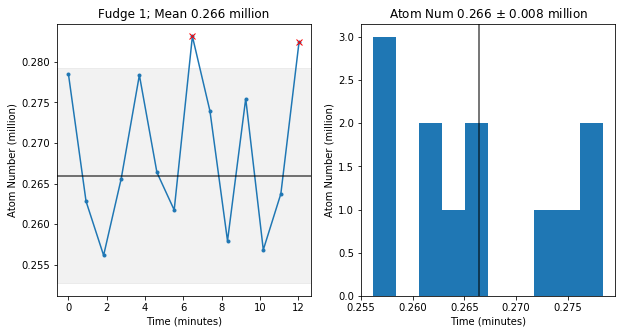

In [13]:
atom_num_filter(df, keep=0.05, display=True, plot=True,)

# Dataset Counter 

# Modified DataFrame Class

In [ ]:


class DataFrame(pd.DataFrame):
    '''Modified Pandas DataFrame''' 
    def __init__(self, data=None, index=None, columns=None, dtype=None, copy=False):
        super(DataFrame, self).__init__(data=None, index=None, columns=None, dtype=None, copy=False)
    
    @property
    def side(self, ):
        return 'yeah'

In [ ]:
df = DataFrame()
df['a'] = np.arange(5)
df['b'] = np.arange(5) +5

In [ ]:
df

In [ ]:
df_ = df['a']

In [ ]:
df_[0] = 10

In [ ]:
df